In [1]:
import sys
root = "/data/luojaa/eukgen/"
sys.path.append(root)

In [2]:
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [71]:
delete = "Thermoplasmata, Bdellovirbrionota, Nitrospirota, Deltaproteobacteria, Thermotogae, Chloroflexota, Deinococcota, Mycoplasmatota, Acidobacteriota, Campylobacterota, Chlamydiia, Spirochaetota, Thermodesulfobacteriota, Campylobacterota".split(", ")

In [73]:
tree_data = pd.read_csv("/data/luojaa/eukgen/microcosm/final_data/tree_data_merged.tsv", sep = "\t").set_index("tree_name").dropna(axis=1)
kegg_annot = pd.read_csv("/data/tobiassonva/data/eukgen/processing/euk72_ep/euk72_ep.KEGG_annotation.swapped_names.tsv", sep = "\t")
annotated_clusters = set(kegg_annot.Query)
tree_data_annot = tree_data[tree_data.index.isin(annotated_clusters)].reset_index()
tree_data_annot_tmp = tree_data_annot.set_index("tree_name")
kegg_annot_tmp = kegg_annot.set_index("Query")[["Target", "Score", "Description", "Pairwise_cov"]]
tree_data_mapped = pd.merge(tree_data_annot_tmp, kegg_annot_tmp, left_index= True, right_index= True, how= "left")#.drop("Unnamed: 0", axis = 1)
tree_data_tophits = tree_data_mapped.sort_values(["euk_clade_rep", "Score"], ascending = False).drop_duplicates(["euk_clade_rep", "prok_clade_rep"])

In [74]:
ec_koginfo = pd.read_csv("/data/luojaa/kegg_stats/KOG_merged.tsv", sep = "\t")
ec_koginfo["EC_single"] = ec_koginfo["EC"].apply(lambda x: x.split("|"))
ec_koginfo = ec_koginfo.explode("EC_single")
ec_2kog = ec_koginfo[ec_koginfo.EC_single != "none" ].loc[:,["kogid", "name", "EC_single"]]
ec_2kogs = ec_2kog.groupby("EC_single")["kogid"].apply(lambda x: "|".join(set(x))).reset_index().rename(columns={"EC_single":"EC","kogid":"KOGS"})

ec_2kog_dict = ec_2kog.drop("name", axis = 1).set_index("kogid").to_dict()["EC_single"]
ec_kogs = set(ec_2kog[~ec_2kog.EC_single.str.contains("-")].kogid)
tree_data_mapped_2ec = tree_data_tophits[tree_data_tophits.Target.isin(ec_kogs)].reset_index()
tree_data_mapped_2ec["EC"] = tree_data_mapped_2ec.Target.apply(lambda x: ec_2kog_dict[x])
tree_data_mapped_2ec = tree_data_mapped_2ec[~tree_data_mapped_2ec.prok_taxa.isin(delete)]

In [83]:
tree_data_dl = pd.read_csv("/data/luojaa/eukgen/microcosm_dl_final_tree_data.tsv", sep = "\t").dropna()
tree_data_dl["EC"] = tree_data_dl.tree_name.apply(lambda x: x.split("_")[0])
dl_annot = pd.read_csv("/data/luojaa/eukgen/microcosm/repseq.microcosms.tmp.tsv", sep = "\t").drop("domain", axis = 1).rename(columns = {"Query":"euk_clade_rep"})

ec_descriptions = pd.read_csv("/data/luojaa/microcosm_metadata/brenda_ec_mappings.tsv", sep = "\t")
ec_info = pd.merge(ec_2kogs, ec_descriptions, on="EC", how="right").drop("comments", axis=1)
tree_data_dl_mapped = pd.merge(tree_data_dl, dl_annot, on=["euk_clade_rep", "EC"], how="left")
tree_data_dl_mapped = pd.merge(tree_data_dl_mapped, ec_info, on="EC", how="left")
tree_data_dl_mapped.fillna("None", inplace=True)
tree_data_dl_mapped = tree_data_dl_mapped.set_index("tree_name")
tree_data_dl_mapped = tree_data_dl_mapped[~tree_data_dl_mapped.prok_taxa.isin(delete)]

In [117]:
trees_dl_cELW = tree_data_dl_mapped[tree_data_dl_mapped["c-ELW"].between(.4,1) & (tree_data_dl_mapped.logL != -1)].reset_index()#.drop("index")
trees_cELW = tree_data_mapped_2ec[(tree_data_mapped_2ec.logL != -1)].reset_index().drop("index", axis = 1)
trees_cELW["EC_KOG"] = trees_cELW.EC + "_" + trees_cELW.Target
ec2cELWsum = {}
for eckog in set(trees_cELW["EC_KOG"]):
    ec2cELWsum[eckog] = len(trees_cELW[trees_cELW.EC_KOG == eckog]["euk_clade_rep"].unique())
trees_cELW["cELW_norm"] = trees_cELW["c-ELW"] / trees_cELW.EC_KOG.apply(lambda x: ec2cELWsum[x])
trees_cELW = trees_cELW[trees_cELW["c-ELW"].between(.4,1)]

# # important: write to output for sankeyt analysis
# trees_cELW.to_csv("/data/luojaa/eukgen/microcosm/trees_cELW_sankey.final.tsv", sep = "\t", index = None)
# trees_dl_cELW.to_csv("/data/luojaa/eukgen/microcosm/trees_dl_cELW_sankey.final.tsv", sep = "\t", index = None)

In [87]:
kog_brite = pd.read_csv("/data/luojaa/kegg_stats/KOG_merged.tsv", sep = "\t")
brite_desc = pd.read_csv("/data/tobiassonva/data/databases/kegg/kegg_metadata/KOG_brite_map.tsv", dtype=str, sep = "\t").set_index("brite_id")
brite_desc = brite_desc[~brite_desc.brite_B.isin(["09191", "09192", "09193"])] # unclassified
brite_b_desc = brite_desc.drop(["brite_C", "level"], axis = 1).drop_duplicates(["brite_A","brite_B"])
brite_b_desc = brite_b_desc[brite_b_desc.brite_B != "none"]
brite_c_desc = brite_desc[brite_desc.brite_C != "none"]
brite_c_2desc = brite_c_desc.reset_index().set_index("brite_C")["name"].to_dict()
def get_brite_c_desc(c_ids):
    c_ids_list = c_ids.split("|")
    desc_list = []
    for c_id in c_ids_list:
        try:
            desc = brite_c_2desc[c_id]
            desc_list += [desc]
        except KeyError:
            desc = "Unclassified"
            desc_list += [desc]
    return "|".join(desc_list)
kog_brite["description_brite_c"] = kog_brite["brite_C"].apply(lambda x: get_brite_c_desc(x))

In [88]:
kog_functions = pd.read_csv('/data/luojaa/uid_stats/kog_functions.tsv', sep = '\t').drop_duplicates("KOGID")
category_data = pd.read_csv('/data/luojaa/kegg_stats/kegg_categories.tsv', sep = '\t')
category_data = pd.merge(category_data, kog_functions, on = "KOGID", how = "outer").dropna()
module_data = category_data[category_data["CATEGORY_ID"].str.startswith("M")]
pathway_data = category_data[category_data["CATEGORY_ID"].str.contains("map")]

In [171]:
kogs_dl

{'K13997'}

In [173]:
tree_data_mapped_2ec.Target.contains("|".join(kogs)

0         K01647
1         K01647
2         K01647
3         K01647
4         K01647
           ...  
160500    K01890
160502    K01890
160504    K01890
160506    K01890
160507    K01890
Name: Target, Length: 144425, dtype: object

In [175]:
# generate summary plots
cELW_dl_breakdowns, cELW_breakdowns = {}, {}
# brite_b_desc = brite_desc.drop(["brite_C", "level"], axis = 1).drop_duplicates(["brite_A","brite_B"])
# brite_b_desc = brite_b_desc[brite_b_desc.brite_B != "none"]
brite2desc = brite_b_desc[brite_b_desc.brite_A == "09100"].drop(["brite_A", "brite_B"], axis = 1).to_dict()["name"]

# ec_2kog_dict = ec_2kog.drop("name", axis = 1).set_index("kogid").to_dict()["EC_single"]
# ec_kogs = set(ec_2kog[~ec_2kog.EC_single.str.contains("-")].kogid)
# tree_data_mapped_2ec = tree_data_mapped[tree_data_mapped.Target.isin(ec_kogs)]
for briteid in list(brite2desc.keys()):
    print(briteid, brite2desc[briteid])
    kogs = set(kog_brite[(kog_brite.brite_B.str.contains(briteid))].kogid)
    trees_filtered = tree_data_mapped_2ec[tree_data_mapped_2ec.Target.isin(kogs)].reset_index()
    trees_filtered["EC"] = trees_filtered.Target.apply(lambda x: ec_2kog_dict[x] if x in ec_2kog_dict.keys() else "None")
    trees_cELW_breakdown = trees_filtered[trees_filtered.EC != None]
    # normalize old microcosms to EC number
    ec2cELWsum = {}
    for ec in list(trees_cELW_breakdown["EC"]):
        ec2cELWsum[ec] = trees_cELW_breakdown[trees_cELW_breakdown.EC == ec]["c-ELW"].sum()
    trees_cELW_breakdown["cELW_norm"] = trees_cELW_breakdown["c-ELW"] / trees_cELW_breakdown.EC.apply(lambda x: ec2cELWsum[x])
    trees_cELW_breakdown = trees_cELW_breakdown[(trees_cELW_breakdown['c-ELW'].between(0.4, 1))
                      & ~((trees_cELW_breakdown['c-ELW'].between(0.99, 1) & (trees_cELW_breakdown.prok_taxa != 'Asgard')))
                      & ((trees_cELW_breakdown['deltaL'] != -1) | (trees_cELW_breakdown.prok_taxa == 'Asgard'))
                      & (trees_cELW_breakdown.euk_LCA.isin(['Eukaryota', 'cellular organisms']))
                      & (trees_cELW_breakdown.euk_scope_len > 5)]
    cELW_freq = trees_cELW_breakdown.groupby("prok_taxa")["cELW_norm"].sum() / sum(trees_cELW_breakdown.groupby("prok_taxa")["cELW_norm"].sum())
    cELW_breakdowns[brite2desc[briteid]] = cELW_freq.sort_values()
    print(len(trees_cELW_breakdown))
for briteid in list(brite2desc.keys()):
    print(briteid, brite2desc[briteid])
    kogs_dl = set(kog_brite[(kog_brite.brite_B.str.contains(briteid))].kogid)
    trees_dl_filtered = tree_data_dl_mapped[tree_data_dl_mapped.KOGS.str.contains("|".join(kogs_dl))].reset_index()
    trees_dl_cELW_breakdown = trees_dl_filtered[(trees_dl_filtered['c-ELW'].between(0.4, 1))
                      & ~((trees_dl_filtered['c-ELW'].between(0.99, 1) & (trees_dl_filtered.prok_taxa != 'Asgard')))
                      & ((trees_dl_filtered['deltaL'] != -1) | (trees_dl_filtered.prok_taxa == 'Asgard'))
                      & (trees_dl_filtered.euk_LCA.isin(['Eukaryota', 'cellular organisms']))
                      & (trees_dl_filtered.euk_scope_len > 5)]
    cELW_dl_freq = trees_dl_cELW_breakdown.groupby("prok_taxa")["c-ELW"].sum() / sum(trees_dl_cELW_breakdown.groupby("prok_taxa")["c-ELW"].sum())
    cELW_dl_breakdowns[brite2desc[briteid]] = cELW_dl_freq.sort_values()
    print(len(trees_dl_cELW_breakdown))

09101 Carbohydrate metabolism
790
09102 Energy metabolism
276
09103 Lipid metabolism
477
09104 Nucleotide metabolism
236
09105 Amino acid metabolism
670
09106 Metabolism of other amino acids
295
09107 Glycan biosynthesis and metabolism
321
09108 Metabolism of cofactors and vitamins
490
09109 Metabolism of terpenoids and polyketides
114
09110 Biosynthesis of other secondary metabolites
186
09111 Xenobiotics biodegradation and metabolism
258
09112 Not included in regular maps
0
09101 Carbohydrate metabolism
233
09102 Energy metabolism
115
09103 Lipid metabolism
148
09104 Nucleotide metabolism
103
09105 Amino acid metabolism
253
09106 Metabolism of other amino acids
119
09107 Glycan biosynthesis and metabolism
51
09108 Metabolism of cofactors and vitamins
170
09109 Metabolism of terpenoids and polyketides
41
09110 Biosynthesis of other secondary metabolites
61
09111 Xenobiotics biodegradation and metabolism
74
09112 Not included in regular maps
0


In [177]:
for briteid in list(brite2desc.keys()):
    kogs_dl = set(kog_brite[(kog_brite.brite_B.str.contains(briteid))].kogid)
    print(len(kogs_dl))

1037
807
540
298
837
293
637
663
871
785
528
1


In [168]:
# # all metabolic kogs
kogs_metabolic = []
for bid in list(brite2desc.keys()):
    kogs_metabolic += list(kog_brite[(kog_brite.brite_B.str.contains(bid))].kogid.unique())
kogs_metabolic = set(kogs_metabolic)

trees_filtered = tree_data_mapped_2ec[tree_data_mapped_2ec.Target.isin(kogs_metabolic)].reset_index()
trees_filtered["EC"] = trees_filtered.Target.apply(lambda x: ec_2kog_dict[x] if x in ec_2kog_dict.keys() else "None")
trees_cELW_breakdown = trees_filtered[trees_filtered.EC != None]
# normalize old microcosms to EC number
ec2cELWsum = {}
for ec in list(trees_cELW_breakdown["EC"]):
    ec2cELWsum[ec] = trees_cELW_breakdown[trees_cELW_breakdown.EC == ec]["c-ELW"].sum()
trees_cELW_breakdown["cELW_norm"] = trees_cELW_breakdown["c-ELW"] / trees_cELW_breakdown.EC.apply(lambda x: ec2cELWsum[x])
trees_cELW_breakdown = trees_cELW_breakdown[(trees_cELW_breakdown['c-ELW'].between(0.4, 1))
                      & ~((trees_cELW_breakdown['c-ELW'].between(0.99, 1) & (trees_cELW_breakdown.prok_taxa != 'Asgard')))
                      & ((trees_cELW_breakdown['deltaL'] != -1) | (trees_cELW_breakdown.prok_taxa == 'Asgard'))
                      & (trees_cELW_breakdown.euk_LCA.isin(['Eukaryota', 'cellular organisms']))
                      & (trees_cELW_breakdown.euk_scope_len > 5)]
cELW_freq = trees_cELW_breakdown.groupby("prok_taxa")["cELW_norm"].sum() / sum(trees_cELW_breakdown.groupby("prok_taxa")["cELW_norm"].sum())

trees_dl_filtered = tree_data_dl_mapped[tree_data_dl_mapped.KOGS.str.contains("|".join(kogs_metabolic))].reset_index()
trees_dl_cELW_breakdown = trees_dl_filtered[(trees_dl_filtered['c-ELW'].between(0.4, 1))
                  & ~((trees_dl_filtered['c-ELW'].between(0.99, 1) & (trees_dl_filtered.prok_taxa != 'Asgard')))
                  & ((trees_dl_filtered['deltaL'] != -1) | (trees_dl_filtered.prok_taxa == 'Asgard'))
                  & (trees_dl_filtered.euk_LCA.isin(['Eukaryota', 'cellular organisms']))
                  & (trees_dl_filtered.euk_scope_len > 5)]
cELW_dl_freq = trees_dl_cELW_breakdown.groupby("prok_taxa")["c-ELW"].sum() / sum(trees_dl_cELW_breakdown.groupby("prok_taxa")["c-ELW"].sum())

Text(0.5, 1.0, 'All metabolic KOGs')

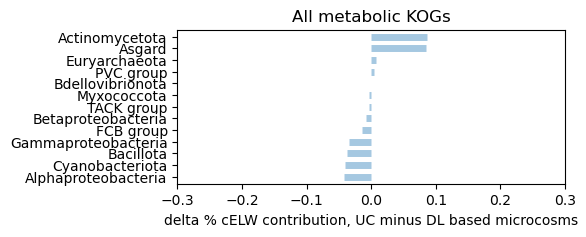

In [197]:
# new, normalize later
# actino and asgard are equal, likely due to KOGs present in multiple BRITE categories
cELW_delta_df = (cELW_freq - cELW_dl_freq).reset_index()
cELW_delta_df = cELW_delta_df.sort_index(ascending = False).fillna(0)
plt.figure(figsize=(5,2))
plt.hlines(y=cELW_delta_df.sort_values(0).prok_taxa, xmin=0, xmax=cELW_delta_df[0].sort_values(), 
           alpha=0.4, linewidth=5) 
plt.xlim(-.3,.3)
plt.xlabel("delta % cELW contribution, UC minus DL based microcosms")
plt.title(f"All metabolic KOGs")

/tmp/ipykernel_2283058/3677108378.py:2: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



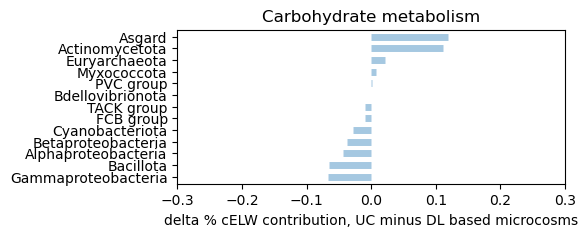

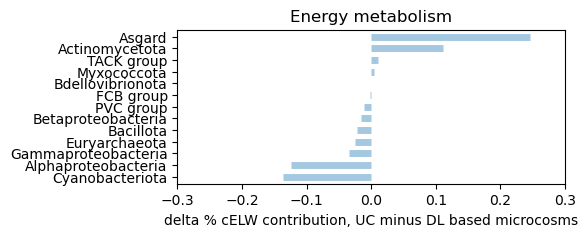

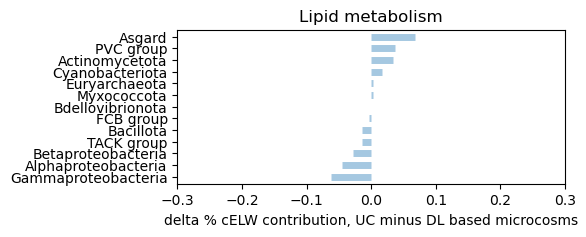

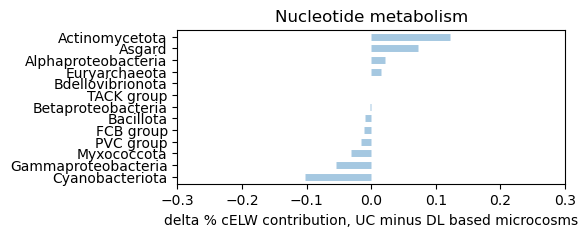

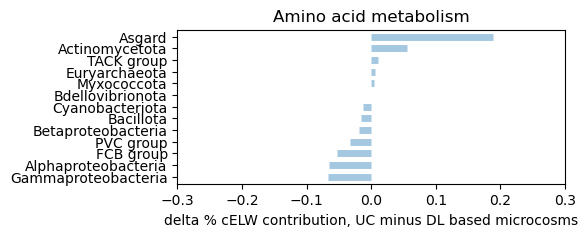

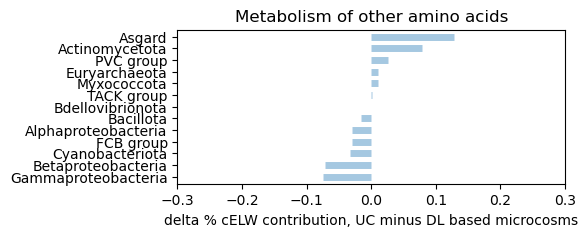

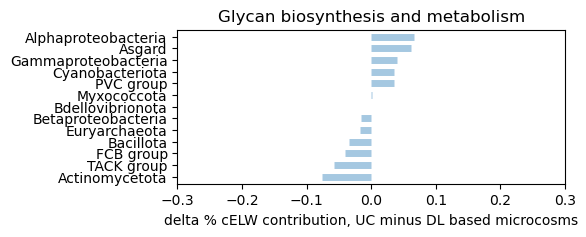

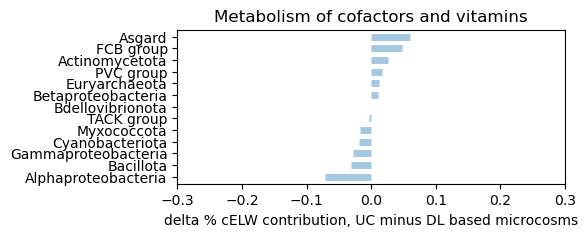

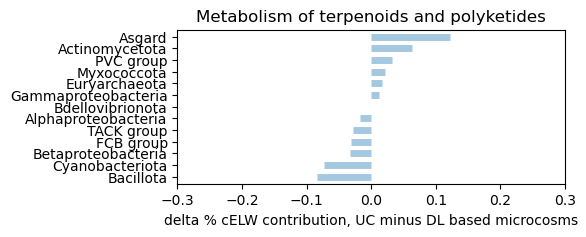

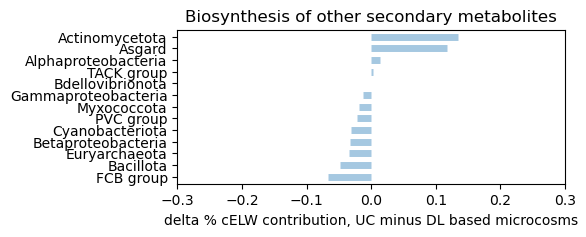

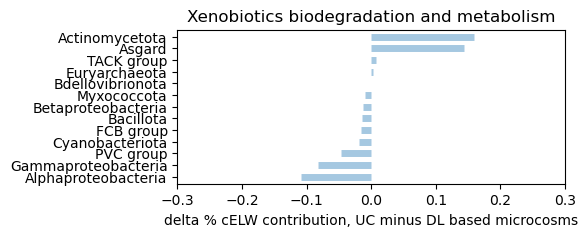

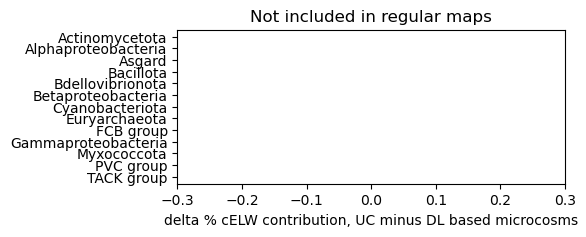

In [176]:
# new
cELW_df = pd.DataFrame(cELW_breakdowns).fillna(0)
cELW_dl_df = pd.DataFrame(cELW_dl_breakdowns).fillna(0)
cELW_delta_df = cELW_df - cELW_dl_df
cELW_delta_df = cELW_delta_df.sort_index(ascending = False).fillna(0)
for colname in cELW_delta_df.columns:
    plt.figure(figsize=(5,2))
    plt.hlines(y=cELW_delta_df.sort_values(colname).index, xmin=0, xmax=cELW_delta_df[colname].sort_values(), 
               alpha=0.4, linewidth=5) 
    plt.xlim(-.3,.3)
    plt.xlabel("delta % cELW contribution, UC minus DL based microcosms")
    plt.title(f"{colname}")

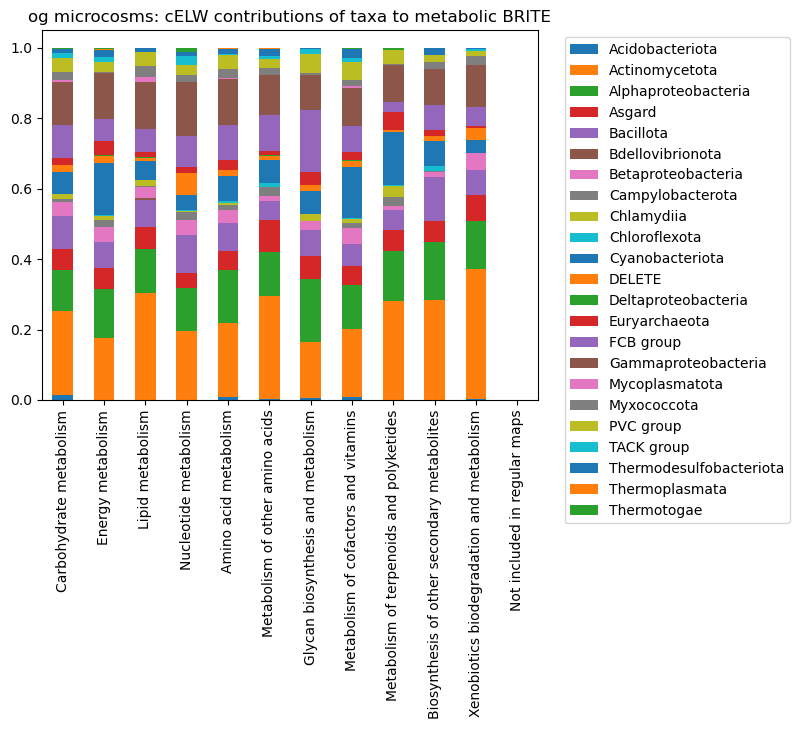

In [13]:
cELW_df.T.plot(kind='bar', stacked=True,
        title='og microcosms: cELW contributions of taxa to metabolic BRITE')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

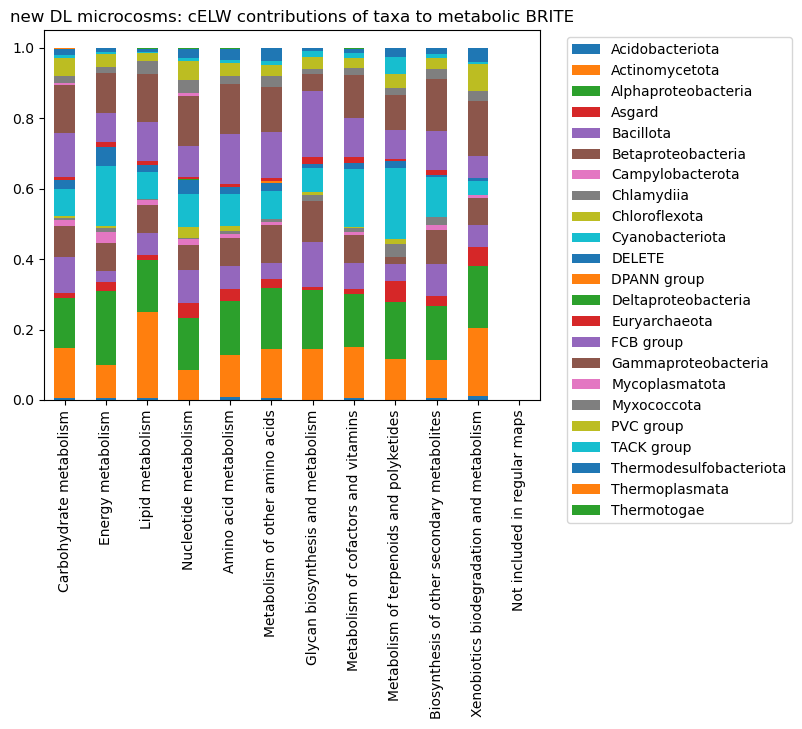

In [14]:
cELW_dl_df = pd.DataFrame(cELW_dl_breakdowns).fillna(0)
cELW_dl_df.T.plot(kind='bar', stacked=True,
        title='new DL microcosms: cELW contributions of taxa to metabolic BRITE')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

### Sankey

In [119]:
# trees_cELW = pd.read_csv("/data/luojaa/eukgen/microcosm/trees_cELW_sankey.updated.tsv", sep = "\t")
# trees_dl_cELW = pd.read_csv("/data/luojaa/eukgen/microcosm/trees_dl_cELW_sankey.updated.tsv", sep = "\t")
trees_cELW = pd.read_csv("/data/luojaa/eukgen/microcosm/trees_cELW_sankey.final.tsv", sep = "\t")
trees_dl_cELW = pd.read_csv("/data/luojaa/eukgen/microcosm/trees_dl_cELW_sankey.final.tsv", sep = "\t")

In [120]:
# map the new taxa onto the old microcosm df
old2new_taxa = trees_dl_cELW.groupby("tree_name")["prok_taxa"].agg(lambda x: ",".join(set(x))).to_dict()
def map_old2new(ec_kog):
    try:
        return old2new_taxa[ec_kog]
    except KeyError:
        try:
            ec_kog = ec_kog.split("_")[0] + "_None"
            return old2new_taxa[ec_kog]
        except KeyError:
            return "None"
        
trees_cELW["prok_taxa_new"] = trees_cELW.EC_KOG.apply(lambda x: map_old2new(x))

In [121]:
sum(trees_cELW.EC.isin(set(trees_dl_cELW.EC)))

5603

In [297]:
def reweighted_cELWs(df_uc):
    g = df_uc.groupby("prok_taxa_new")["cELW_norm"].sum().reset_index()
    g["weight"] = g.iloc[:,0].apply(lambda x: 1 / len(x.split(",")))
    # each microcosm contributes to 1 "taxa weight"
    g["cELW_weighted"] = g["cELW_norm"] * g["weight"]
    g["taxa"] = g.iloc[:,0].apply(lambda x: x.split(","))
    h = g.explode("taxa")
    reweighted = h.groupby("taxa")["cELW_weighted"].sum().sort_values(ascending = False)
    return reweighted[reweighted.index != "None"]
def reweighted_vc(s):
    g = s.value_counts().reset_index()
    g["weight"] = g.iloc[:,0].apply(lambda x: 1 / len(x.split(",")))
    # each microcosm contributes to 1 "taxa weight"
    g["count_weighted"] = g["count"] * g["weight"]
    g["taxa"] = g.iloc[:,0].apply(lambda x: x.split(","))
    h = g.explode("taxa")
    reweighted_vc = h.groupby("taxa")["count_weighted"].sum().round().sort_values(ascending = False)
    return reweighted_vc#[reweighted_vc.index != "None"]

In [123]:
len(trees_cELW.tree_name.unique()), len(trees_cELW.euk_clade_rep.unique())

(6617, 8870)

In [300]:
trees_cELW_dl_plot

,tree_name,Unnamed: 0,euk_clade_rep,euk_clade_size,euk_clade_weight,euk_leaf_clade,euk_LCA,euk_scope,euk_scope_len,prok_clade_rep,...,p-SH_accept,c-ELW,c-ELW_accept,p-AU,p-AU_accept,EC,confidence,KOGS,description,prok_taxa_old
0,1.10.2.2_None,0,EP01040P024583,58,0.878788,False,Eukaryota,Heterolobosea|Euglenida|Sar|Chlorophyta|Rhizar...,12,WP_010510616_1,...,+,0.754,+,0.930,+,1.10.2.2,1.0000,NaN,quinol-cytochrome-c reductase,None
1,1.10.3.2_K00421,0,EP01120P015235,15,0.768627,False,cellular organisms,Rhodophyta|Chlorophyta|Streptophyta|Euglenida|...,6,WP_015162934_1,...,+,0.500,+,0.489,+,1.10.3.2,0.9425,K00421|K05909,laccase,None
2,1.10.3.2_K00421,1,EP01120P015235,15,0.768627,False,cellular organisms,Rhodophyta|Chlorophyta|Streptophyta|Euglenida|...,6,WP_019046876_1,...,+,0.500,+,0.511,+,1.10.3.2,0.9425,K00421|K05909,laccase,None
13,1.10.5.1_K08071,14,EP01156P002285,40,0.461441,False,cellular organisms,Metamonada|Metazoa|Ochrophyta|Ascomycota|Actin...,7,WP_179034155_1,...,+,0.607,+,0.707,+,1.10.5.1,0.9244,K08071,ribosyldihydronicotinamide dehydrogenase (quin...,None
16,1.1.1.102_K04708,12,EP00617P008084,399,0.883614,False,cellular organisms,Streptophyta|Ascomycota|Fungi incertae sedis|M...,21,WP_126670638_1,...,+,0.764,+,0.933,+,1.1.1.102,0.9910,K04708,3-dehydrosphinganine reductase,"Gammaproteobacteria,Alphaproteobacteria,Bacill..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2968,7.2.2.8_K17686,2,EP00027P005890,710,0.951743,False,Eukaryota,Amoebozoa|Choanoflagellata|Metazoa|Fungi incer...,16,JAEOTH010000126.1_1,...,+,0.457,+,0.778,+,7.2.2.8,1.0000,K12956|K17686,P-type Cu+ transporter,"Actinomycetota,Asgard,Cyanobacteriota,FCB grou..."
2973,7.3.2.7_None,1,EP00806P006632,157,0.975155,False,Eukaryota,Ochrophyta|Rhodophyta|Cryptophyceae|Glaucocyst...,11,WP_011432957_1,...,+,0.423,+,0.325,+,7.3.2.7,0.7749,K01551,arsenite-transporting ATPase,None
2974,7.3.2.7_None,3,EP00806P006632,157,0.975155,False,Eukaryota,Ochrophyta|Rhodophyta|Cryptophyceae|Glaucocyst...,11,WP_205633631_1,...,+,0.577,+,0.686,+,7.3.2.7,0.7749,K01551,arsenite-transporting ATPase,None
2979,7.6.2.2_K05658,21,EP00760P035929,557,0.851682,False,Eukaryota,Streptophyta|Ochrophyta|Amoebozoa|Ciliophora|M...,11,WP_176092988_1,...,+,0.537,+,0.859,+,7.6.2.2,1.0000,K05658|K18104|K05659,ABC-type xenobiotic transporter,Actinomycetota


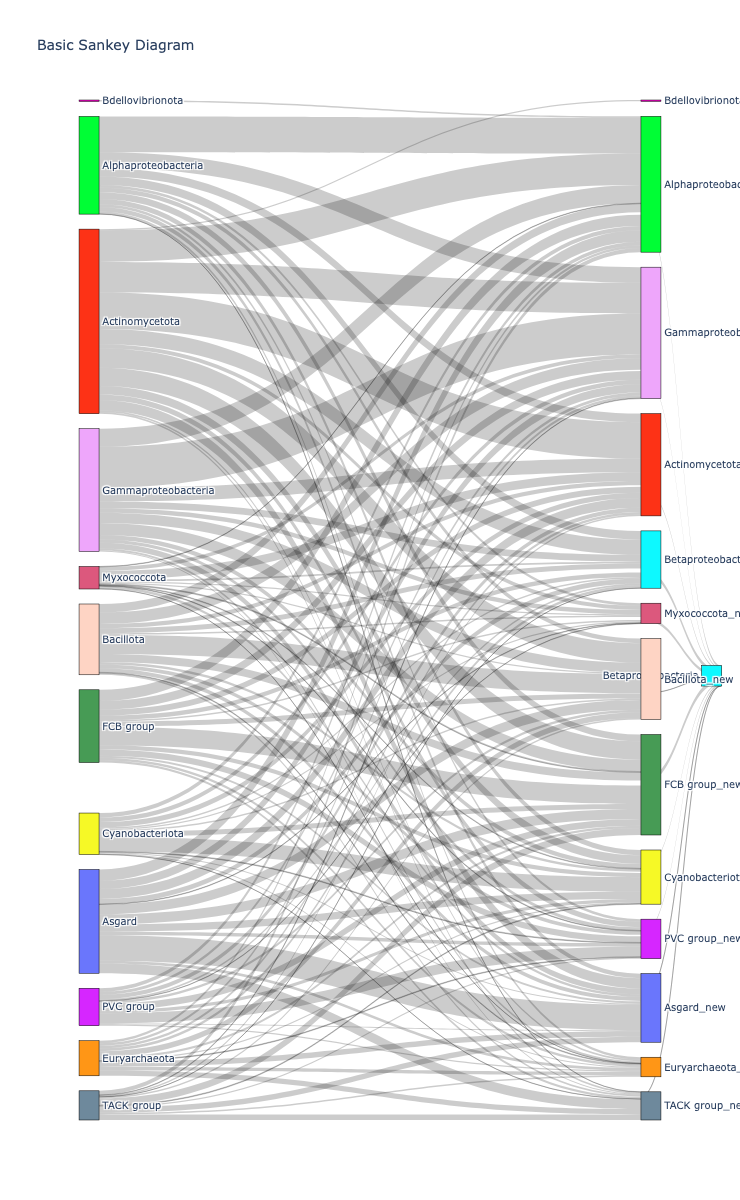

In [298]:
trees_cELW_plot = trees_cELW
trees_cELW_plot = trees_cELW_plot[(trees_cELW_plot['c-ELW'].between(0.4, 1))
                      & ~((trees_cELW_plot['c-ELW'].between(0.99, 1) & (trees_cELW_plot.prok_taxa != 'Asgard')))
                      & ((trees_cELW_plot['deltaL'] != -1) | (trees_cELW_plot.prok_taxa == 'Asgard'))
                      & (trees_cELW_plot.euk_LCA.isin(['Eukaryota', 'cellular organisms']))
                      & (trees_cELW_plot.euk_scope_len > 5)]
#trees_cELW_plot = trees_cELW[(trees_cELW['c-ELW'].between(0.4, 1))]

trees_cELW_dl_plot = trees_dl_cELW
trees_cELW_dl_plot = trees_cELW_dl_plot[(trees_cELW_dl_plot['c-ELW'].between(0.4, 1))
                      & ~((trees_cELW_dl_plot['c-ELW'].between(0.99, 1) & (trees_cELW_dl_plot.prok_taxa != 'Asgard')))
                      & ((trees_cELW_dl_plot['deltaL'] != -1) | (trees_cELW_dl_plot.prok_taxa == 'Asgard'))
                      & (trees_cELW_dl_plot.euk_LCA.isin(['Eukaryota', 'cellular organisms']))
                      & (trees_cELW_dl_plot.euk_scope_len > 5)]
#trees_cELW_dl_plot = trees_dl_cELW[(trees_dl_cELW['c-ELW'].between(0.4, 1))]

label = list(pd.concat([trees_cELW_dl_plot.prok_taxa, trees_cELW_plot.prok_taxa]).sort_values().unique())
label_all = label + [i + "_new" for i in label] 
cELWs = [reweighted_cELWs(trees_cELW_plot[trees_cELW_plot.prok_taxa == taxa]) for taxa in label]
label_map = {v:k for k, v in dict(enumerate(label)).items()}
source, target, value, j = [], [], [], 0
for i in cELWs:
    target += [label_map[taxa] + 13 for taxa in list(i.index)]
    value += list(i)
    source += [j]*len(i)
    j += 1
    
fig1 = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = label_all,
      color = (px.colors.qualitative.Light24)[:13]*2
    ),
    link = dict(
      source = source, # indices correspond to labels
      target = target,
      value = value
  ))])

fig1.update_layout(title_text="Basic Sankey Diagram", font_size=10, autosize=False, width=800, height=1200)
fig1.show()


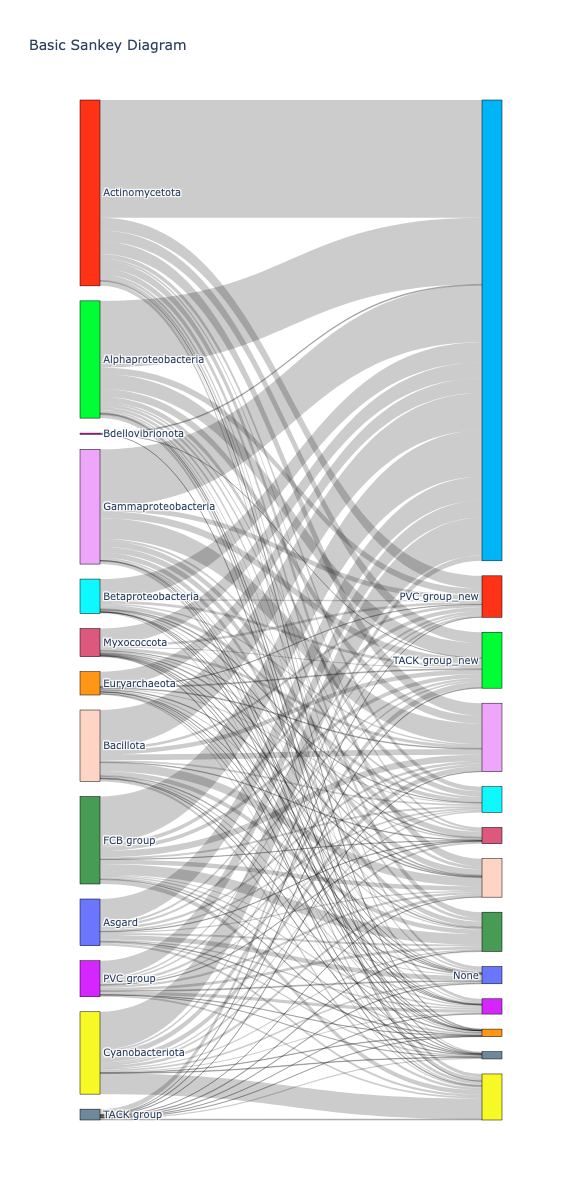

In [97]:
trees_cELW_plot = trees_cELW
trees_cELW_plot = trees_cELW_plot[trees_cELW_plot["c-ELW"] > .52]
label = list(pd.concat([trees_dl_cELW.prok_taxa, trees_cELW.prok_taxa]).sort_values().unique())
label_all = label + [i + "_new" for i in label] + ["None"]
vcs = [reweighted_vc(trees_cELW_plot[trees_cELW_plot.prok_taxa == taxa].prok_taxa_new) for taxa in label]
label_map = {v:k for k, v in dict(enumerate(label + ["None"])).items()}
source, target, value, j = [], [], [], 0
for i in vcs:
    target += [label_map[taxa] + 24 for taxa in list(i.index)]
    value += list(i)
    source += [j]*len(i)
    j += 1
    
fig2 = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = label_all,
      color = px.colors.qualitative.Light24 * 2
    ),
    link = dict(
      source = source, # indices correspond to labels
      target = target,
      value = value
  ))])

fig2.update_layout(title_text="Basic Sankey Diagram", font_size=10, autosize=False, width=800, height=1200)
fig2.show()


In [214]:
# reverse mapping, old onto new
new2old_taxa = trees_cELW.groupby("EC_KOG")["prok_taxa"].agg(lambda x: ",".join(set(x))).to_dict()
new_tids = set(trees_dl_cELW.tree_name)
new_none2old_taxa = {}
for old_taxa in new2old_taxa.keys():
    if old_taxa not in new_tids:
        ec_none = old_taxa.split("_")[0] + "_None"
        new_none2old_taxa[ec_none] = new2old_taxa[old_taxa]
def map_new2old(ec_kog):
    try:
        return new2old_taxa[ec_kog]
    except KeyError:
        try:
            return new_none2old_taxa[ec_kog]
        except KeyError:
            return "None"
trees_dl_cELW["prok_taxa_old"] = trees_dl_cELW.tree_name.apply(lambda x: map_new2old(x))

In [215]:
#brite_C mapping

In [216]:
kog_2briteC = kog_brite.rename(columns={"kogid":"Target"}).loc[:,["Target", "brite_C", "description_brite_c"]]

In [217]:
# def brite_c_counts(s):
#     s_list = s.str.split("|")
#     s_explode = s_list.explode()
#     return s_explode.value_counts(normalize = True)

In [218]:
#global_breakdown = i.set_index("cELW_norm").description_brite_c.str.split("|").explode().reset_index().groupby("description_brite_c")["cELW_norm"].sum().sort_values(ascending=False)

In [219]:
# filter out microcosms that have an EC but not an EC-KOG match (so mapping reads "None") between UC/DL
dl_ECs = set(trees_dl_cELW.EC)
uc_ECs = set(trees_cELW.EC)
uc_matched_ECs = set(trees_cELW[trees_cELW["prok_taxa_new"] == "None"].EC).intersection(dl_ECs)
dl_matched_ECs = set(trees_dl_cELW[trees_dl_cELW["prok_taxa_old"] == "None"].EC).intersection(uc_ECs)


In [288]:
h

,tree_name,euk_clade_rep,euk_clade_size,euk_clade_weight,euk_leaf_clade,euk_LCA,euk_scope,euk_scope_len,prok_clade_rep,prok_clade_size,...,Score,Description,Pairwise_cov,EC,EC_KOG,cELW_norm,prok_taxa_new,name,brite_C,description_brite_c
9180,EP00449P062505,EP00418P073135,6,0.545455,False,Eukaryota,Fungi incertae sedis|Bigyra|Dinophyceae|Euglenida,4,WP_204226560_1,27,...,130.0,lactoylglutathione lyase [EC:4.4.1.5],0.602941,4.4.1.5,4.4.1.5_K01759,0.018182,Gammaproteobacteria,"GLO1, gloA; lactoylglutathione lyase [EC:4.4.1.5]",00620,Pyruvate metabolism [PATH:ko00620]
4000,EP01136P025690,EP00133P010331,19,0.327586,False,Dikarya,Basidiomycota|Ascomycota,2,WP_126388697_1,53,...,802.6,"catechol 1,2-dioxygenase [EC:1.13.11.1]",0.959732,1.13.11.1,1.13.11.1_K03381,0.100000,Alphaproteobacteria,"catA; catechol 1,2-dioxygenase [EC:1.13.11.1]",00361|00623|00362|00364,Chlorocyclohexane and chlorobenzene degradatio...
7855,EP00944P007228,EP00063P061965,26,1.000000,False,Eukaryota,Bigyra|Euglenida|Rhizaria|Choanoflagellata|Met...,8,WP_026033918_1,22,...,602.4,aspartate beta-hydroxylase [EC:1.14.11.16],0.531707,1.14.11.16,1.14.11.16_K00476,0.036364,None,ASPH; aspartate beta-hydroxylase [EC:1.14.11.16],04260|04020,Cardiac muscle contraction [PATH:ko04260]|Calc...
7854,EP00747P115595,EP01112P004404,28,1.000000,False,Eukaryota,Euglenida|Metazoa|Haptista|Amoebozoa|Cryptophy...,12,WP_071914856_1,4,...,133.8,heparanase [EC:3.2.1.166],0.673597,3.2.1.166,3.2.1.166_K07964,0.036364,None,HPSE; heparanase [EC:3.2.1.166],00531|00536|05205,Glycosaminoglycan degradation [PATH:ko00531]|G...
7558,EP01036P040203,EP00879P004188,16,0.444444,False,Eukaryota,Chlorophyta|Apicomplexa|Euglenida|Amoebozoa|Di...,9,WP_016353869_1,78,...,737.3,malate dehydrogenase [EC:1.1.1.37],0.768072,1.1.1.37,1.1.1.37_K00025,0.040000,None,MDH1; malate dehydrogenase [EC:1.1.1.37],00710|04964|00630|00620|00270|00020,Carbon fixation in photosynthetic organisms [P...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,EP00050P012951,EP00401P083163,333,1.000000,False,Eukaryota,Amoebozoa|Haptista|Fungi incertae sedis|Metazo...,17,WP_077208242_1,3,...,944.6,katanin p60 ATPase-containing subunit A1 [EC:5...,0.635593,5.6.1.1,5.6.1.1_K07767,0.333333,"Asgard,Euryarchaeota",SPAST; spastin [EC:5.6.1.1],04812,Cytoskeleton proteins [BR:ko04812]
703,EP00578P018270,EP00259P013651,203,0.975962,False,Eukaryota,Amoebozoa|Streptophyta|Chlorophyta|Rhodophyta|...,11,WP_016352612_1,292,...,2570.8,phosphoenolpyruvate carboxylase [EC:4.1.1.31],0.928571,4.1.1.31,4.1.1.31_K01595,0.333333,Gammaproteobacteria,ppc; phosphoenolpyruvate carboxylase [EC:4.1.1...,00620|00710|00720|00680,Pyruvate metabolism [PATH:ko00620]|Carbon fixa...
704,EP01031P042676,EP00077P021156,11,0.314286,False,Eukaryota,Rhizaria|Haptista|Metazoa,3,WP_146319669_1,3,...,475.0,linoleoyl-CoA desaturase [EC:1.14.19.3],0.879552,1.14.19.3,1.14.19.3_K00508,0.333333,None,E1.14.19.3; linoleoyl-CoA desaturase [EC:1.14....,00591|01004,Linoleic acid metabolism [PATH:ko00591]|Lipid ...
1575,EP00286P025649,EP00249P014727,20,1.000000,False,Eukaryota,Haptista|Chlorophyta|Streptophyta|Bigyra|Basid...,7,WP_158775408_1,88,...,1003.7,2-oxoisovalerate dehydrogenase E1 component su...,0.876404,1.2.4.4,1.2.4.4_K00166,0.200000,Gammaproteobacteria,"BCKDHA, bkdA1; 2-oxoisovalerate dehydrogenase ...",00640|00280|00785,"Propanoate metabolism [PATH:ko00640]|Valine, l..."


In [290]:
taxas = ["Global", "Alphaproteobacteria", "Cyanobacteriota", "Asgard", "Actinomycetota", "Betaproteobacteria"]
cELWs = []
for taxa in taxas:
    trees_cELW_filt = trees_cELW[trees_cELW.prok_taxa == taxa].sort_values(["cELW_norm", "c-ELW"], ascending = False)
    if taxa == "Global":
        trees_cELW_filt = trees_cELW.sort_values(["cELW_norm", "c-ELW"], ascending = False)
    f = pd.merge(trees_cELW_filt, ec_2kog.rename(columns={"EC_single":"EC"}).drop_duplicates("EC"), on = "EC", how = "left").drop(["kogid"], axis = 1)
    g = pd.merge(f, kog_2briteC, on = "Target", how = "left").fillna("None")
    h = g[~g.prok_taxa_new.str.contains(taxa) & ~(g.EC.isin(uc_matched_ECs))].sort_values("c-ELW")
    i = h[(h['c-ELW'].between(0.4, 1))
                      & ~((h['c-ELW'].between(0.99, 1) & (h.prok_taxa != 'Asgard')))
                      & ((h['deltaL'] != -1) | (h.prok_taxa == 'Asgard'))
                      & (h.euk_LCA.isin(['Eukaryota', 'cellular organisms']))
                      & (h.euk_scope_len > 5)].set_index("cELW_norm")
    cELW_dist = i.description_brite_c.str.split("|").explode().reset_index().groupby("description_brite_c")["cELW_norm"].sum().sort_values(ascending=False).iloc[:50]
    cELWs.append(cELW_dist)

In [292]:
taxas = ["Global", "Alphaproteobacteria", "Cyanobacteriota", "Asgard", "Actinomycetota", "Betaproteobacteria"]
cELWs_dl = []
for taxa in taxas:
    trees_cELW_dl_filt = trees_dl_cELW[trees_dl_cELW.prok_taxa == taxa].sort_values(["c-ELW"], ascending = False)
    if taxa == "Global":
        trees_cELW_dl_filt = trees_dl_cELW.sort_values(["c-ELW"], ascending = False)
    l = pd.merge(trees_cELW_dl_filt, ec_2kog.rename(columns={"EC_single":"EC"}).drop_duplicates("EC"), on = "EC", how = "left").drop(["kogid"], axis = 1)
    m = l.fillna("None")
    m["KOGID"] = m.tree_name.apply(lambda x: x.split("_")[1])
    # drop nulls, which are EC_None
    m = pd.merge(m.rename(columns={"KOGID":"Target"}), kog_2briteC, on = "Target", how = "left").dropna()
    n = m[~m.prok_taxa_old.str.contains(taxa) & ~(m.EC.isin(dl_matched_ECs))].sort_values("c-ELW")
    o = n[(n['c-ELW'].between(0.4, 1))
                      & ~((n['c-ELW'].between(0.99, 1) & (n.prok_taxa != 'Asgard')))
                      & ((n['deltaL'] != -1) | (n.prok_taxa == 'Asgard'))
                      & (n.euk_LCA.isin(['Eukaryota', 'cellular organisms']))
                      & (n.euk_scope_len > 5)].set_index("c-ELW")
    cELW_dist = o.description_brite_c.str.split("|").explode().reset_index().groupby("description_brite_c")["c-ELW"].sum().sort_values(ascending=False).iloc[:50]
    cELWs_dl.append(cELW_dist)
    

In [294]:
cELW_breakdowns_UCnotDL = pd.concat(cELWs,axis = 1).fillna(0)
cELW_breakdowns_UCnotDL.columns = taxas
cELW_breakdowns_UCnotDL.to_csv("cELW_norm_comparison.UCnotDL.tsv", sep = "\t")


In [295]:
cELW_breakdowns_DLnotUC = pd.concat(cELWs_dl,axis = 1).fillna(0)
cELW_breakdowns_DLnotUC.columns = taxas
cELW_breakdowns_DLnotUC.to_csv("cELW_comparison.DLnotUC.tsv", sep = "\t")


In [220]:
# track what was missed in DL but picked up in UC 
taxa = "Actinomycetota"
#trees_cELW_frac_filt = trees_cELW_frac[trees_cELW_frac.prok_taxa == taxa].sort_values(["cELW_frac", "c-ELW"], ascending = False)
#f = pd.merge(trees_cELW_frac_filt, ec_2kog.rename(columns={"EC_single":"EC"}).drop_duplicates("EC"), on = "EC", how = "left").drop(["prok_taxa", "c-ELW", "kogid"], axis = 1)
trees_cELW_filt = trees_cELW[trees_cELW.prok_taxa == taxa].sort_values(["cELW_norm", "c-ELW"], ascending = False)
f = pd.merge(trees_cELW_filt, ec_2kog.rename(columns={"EC_single":"EC"}).drop_duplicates("EC"), on = "EC", how = "left").drop(["prok_taxa", "kogid"], axis = 1)
g = pd.merge(f, kog_2briteC, on = "Target", how = "left").fillna("None")
h = g[~g.prok_taxa_new.str.contains(taxa) & ~(g.EC.isin(uc_matched_ECs))].sort_values("c-ELW")
i = h[h["c-ELW"].between(.7,1)]
j = i.name.value_counts()
print([len(num) for num in [g, h, i, j]])

[2205, 1761, 564, 339]


In [48]:
actino_breakdown = i.set_index("cELW_norm").description_brite_c.str.split("|").explode().reset_index().groupby("description_brite_c")["cELW_norm"].sum().sort_values(ascending=False).iloc[:50]

In [49]:
actino_ecs = i.groupby("name")["cELW_norm"].sum().sort_values(ascending=False).iloc[:50]

In [210]:
# track what is new in DL
taxa = "Betaproteobacteria"
#trees_cELW_dl_frac_filt = trees_cELW_dl_frac[trees_cELW_dl_frac.prok_taxa == taxa].sort_values(["cELW_frac", "c-ELW"], ascending = False)
trees_cELW_dl_filt = trees_dl_cELW#[trees_dl_cELW.prok_taxa == taxa].sort_values(["c-ELW"], ascending = False)
l = pd.merge(trees_cELW_dl_filt, ec_2kog.rename(columns={"EC_single":"EC"}).drop_duplicates("EC"), on = "EC", how = "left").drop(["prok_taxa", "kogid"], axis = 1)
m = l.fillna("None")
m["KOGID"] = m.tree_name.apply(lambda x: x.split("_")[1])
m = pd.merge(m.rename(columns={"KOGID":"Target"}), kog_2briteC, on = "Target", how = "left").fillna("None")
n = m[~m.prok_taxa_old.str.contains(taxa) & ~(m.EC.isin(dl_matched_ECs))].sort_values("c-ELW")
o = n[n["c-ELW"] > .7]

p = list(o.name.unique())
print([len(num) for num in [m, n, o, p]])

AttributeError: 'DataFrame' object has no attribute 'prok_taxa_old'

In [493]:
o.set_index("c-ELW").description_brite_c.str.split("|").explode().reset_index().groupby("description_brite_c")["c-ELW"].sum().sort_values(ascending=False).iloc[:50]

description_brite_c
None                                                                  93.314
Unclassified                                                          42.461
Transfer RNA biogenesis [BR:ko03016]                                  34.186
Amino acid related enzymes [BR:ko01007]                               29.330
Peptidases and inhibitors [BR:ko01002]                                28.947
Purine metabolism [PATH:ko00230]                                      27.295
Exosome [BR:ko04147]                                                  27.049
Amino sugar and nucleotide sugar metabolism [PATH:ko00520]            25.874
Glycine, serine and threonine metabolism [PATH:ko00260]               22.387
Glyoxylate and dicarboxylate metabolism [PATH:ko00630]                21.885
Terpenoid backbone biosynthesis [PATH:ko00900]                        21.873
Valine, leucine and isoleucine degradation [PATH:ko00280]             20.430
Cysteine and methionine metabolism [PATH:ko00270]       

In [487]:
o.groupby("name")["c-ELW"].sum().sort_values(ascending=False).iloc[:50]

name
mmsA, iolA, ALDH6A1; malonate-semialdehyde dehydrogenase (acetylating) / methylmalonate-semialdehyde dehydrogenase [EC:1.2.1.18 1.2.1.27]                                             2.933
ACACA; acetyl-CoA carboxylase / biotin carboxylase 1 [EC:6.4.1.2 6.3.4.14 2.1.3.15]                                                                                                   1.857
GARS, glyS1; glycyl-tRNA synthetase [EC:6.1.1.14]                                                                                                                                     1.833
None                                                                                                                                                                                  1.778
rne; ribonuclease E [EC:3.1.26.12]                                                                                                                                                    1.596
rluC; 23S rRNA pseudouridine955/2504/2580 synthase [EC:

In [307]:
#list(g[(g["c-ELW"] > .7) & (g["cELW_frac"] > .3)].name.unique())
#list(g[(g["c-ELW"] > .7) ].name.unique())
len(set(p).difference(set(j)))

109

In [19]:
def reweighted_cELWs_dl(df_uc):
    g = df_uc.groupby("prok_taxa_old")["c-ELW"].sum().reset_index()
    g["weight"] = g.iloc[:,0].apply(lambda x: 1 / len(x.split(",")))
    # each microcosm contributes to 1 "taxa weight"
    g["cELW_weighted"] = g["c-ELW"] * g["weight"]
    g["taxa"] = g.iloc[:,0].apply(lambda x: x.split(","))
    h = g.explode("taxa")
    reweighted = h.groupby("taxa")["cELW_weighted"].sum().round().sort_values(ascending = False)
    return reweighted#[reweighted.index != "None"]
# def reweighted_vc(s):
#     g = s.value_counts().reset_index()
#     g["weight"] = g.iloc[:,0].apply(lambda x: 1 / len(x.split(",")))
#     # each microcosm contributes to 1 "taxa weight"
#     g["count_weighted"] = g["count"] * g["weight"]
#     g["taxa"] = g.iloc[:,0].apply(lambda x: x.split(","))
#     h = g.explode("taxa")
#     reweighted_vc = h.groupby("taxa")["count_weighted"].sum().round().sort_values(ascending = False)
#     return reweighted_vc#[reweighted_vc.index != "None"]

In [35]:
px.colors.qualitative.Light24 

['#FD3216',
 '#00FE35',
 '#6A76FC',
 '#FED4C4',
 '#FE00CE',
 '#0DF9FF',
 '#F6F926',
 '#FF9616',
 '#479B55',
 '#EEA6FB',
 '#DC587D',
 '#D626FF',
 '#6E899C',
 '#00B5F7',
 '#B68E00',
 '#C9FBE5',
 '#FF0092',
 '#22FFA7',
 '#E3EE9E',
 '#86CE00',
 '#BC7196',
 '#7E7DCD',
 '#FC6955',
 '#E48F72']

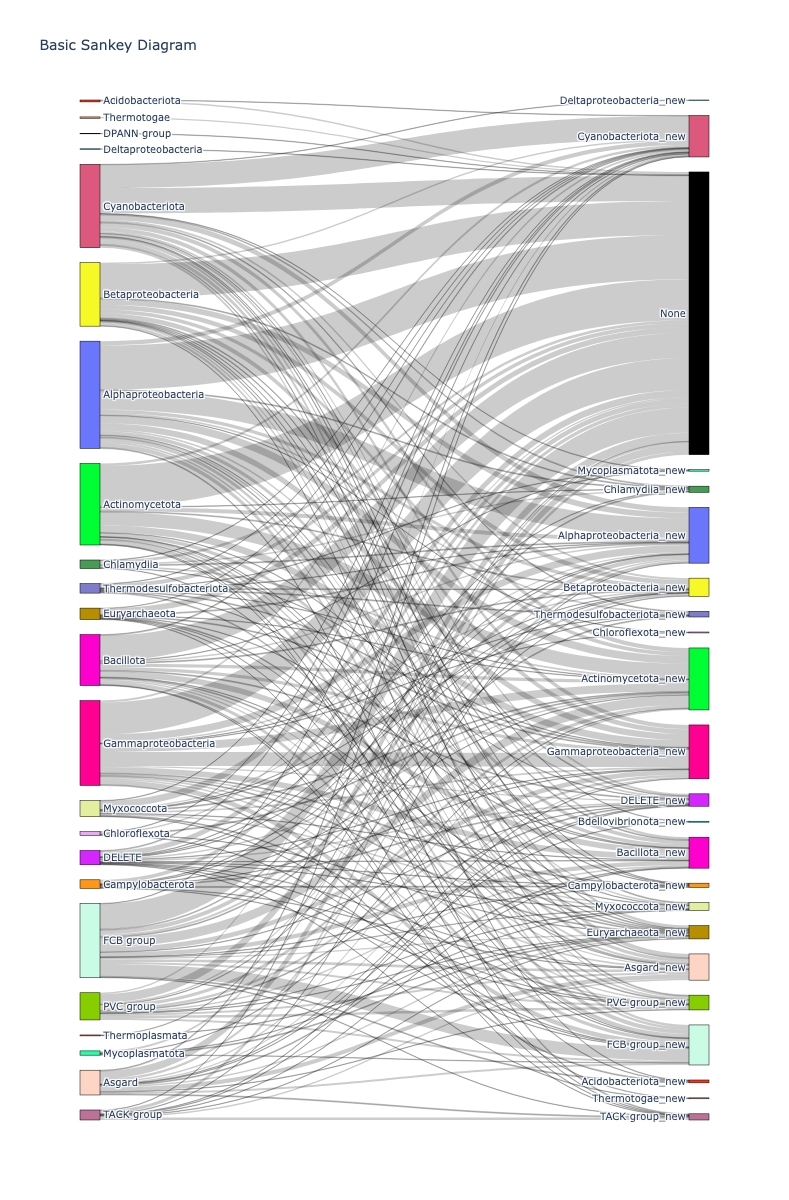

In [188]:
trees_cELW_dl_plot = trees_dl_cELW
trees_cELW_dl_plot = trees_cELW_dl_plot[trees_cELW_dl_plot["c-ELW"] > .52]
label = list(pd.concat([trees_cELW_dl_plot.prok_taxa, trees_cELW.prok_taxa]).sort_values().unique())
label_all = label + [i + "_new" for i in label] + ["None"]
cELWs = [reweighted_cELWs_dl(trees_cELW_dl_plot[trees_cELW_dl_plot.prok_taxa == taxa]) for taxa in label]
label_map = {v:k for k, v in dict(enumerate(label + ["None"])).items()}
source, target, value, j = [], [], [], 0
for i in cELWs:
    target += [label_map[taxa] + 24 for taxa in list(i.index)]
    value += list(i)
    source += [j]*len(i)
    j += 1
    
fig3 = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = label_all,
      color = px.colors.qualitative.Light24 * 2
    ),
    link = dict(
      source = source, # indices correspond to labels
      target = target,
      value = value
  ))])

fig3.update_layout(title_text="Basic Sankey Diagram", font_size=10, autosize=False, width=800, height=1200)
fig3.show()


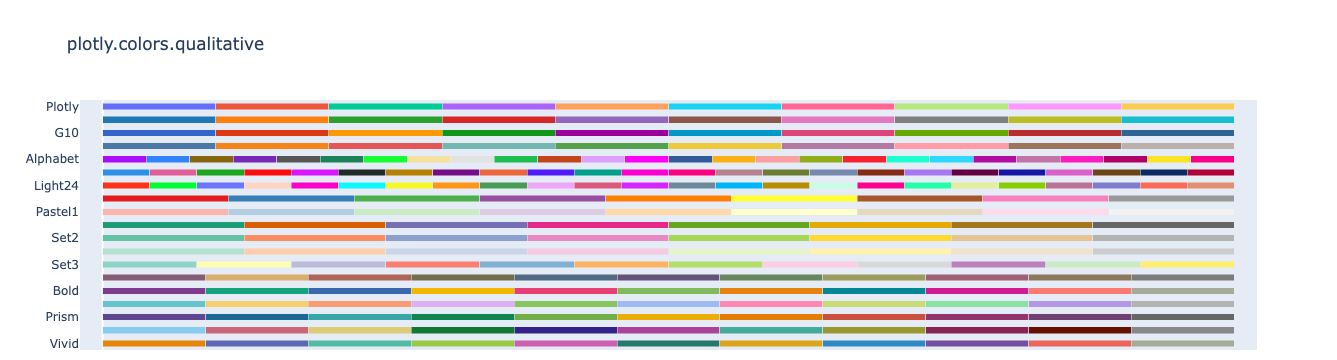

In [268]:
fig = px.colors.qualitative.swatches()
fig.show()